In [13]:
import polars as pl
import numpy as np
import math, json
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
        'font.family': 'serif',
        "font.serif": 'Times',
        'font.size': 15,
        'text.usetex': True,
        'pgf.rcfonts': False,
        'text.latex.preamble': r'\usepackage{amsmath}'
})

warmup_time = 5.0
num_runs = 15

color_M1 = '#7BBE76'
color_M2 = '#0087AC'
color_M3 = '#323B81'

color_C1 = '#FFC913'
color_C2 = '#F20052'
color_C3 = '#8B1F69'

v = '019'
per = 0
num_malicios = 60

results_path = '/home/manav/uav-position-verification-simulator'


In [14]:
def get_summary(fname):
    with open(fname, 'r') as f:
        return json.load(f)

In [15]:
def calculate_confidence_interval(data, confidence=.95):
    n = len(data)
    m = np.mean(data)
    std_dev = scipy.stats.sem(data)
    h = std_dev * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return [m, h]

In [16]:
def get_detection_time(method, num_nodes, lying_intensity):
    detection_times = []
    for r in range(num_runs):
        try:
            summary = get_summary(f'{results_path}/res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.json')
            malicious_nodes = summary['malicious_nodes']
            df = pl.read_csv(f'{results_path}/res/v{v}/{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.csv')
            df = df.filter(pl.col("detected_node").is_in(malicious_nodes))
            # if method == "REPT":
            #     df = df.filter(pl.col("votes_is_malicious") > 1)
            times = df.groupby('detected_node').agg(pl.col('detected_at').min()).sort(pl.col('detected_at'))['detected_at'].to_numpy() - warmup_time
            detection_times.append(times)
        except:
            pass

    mean_detection_times = []
    detection_times_ci = []

    for i in range(num_nodes):
        samples = []
        for s in detection_times:
            try:
                samples.append(s[i])
            except:
                pass

        [m,h] = calculate_confidence_interval(samples)
        mean_detection_times.append(m)
        detection_times_ci.append(h)

    start = 0.005 #if method != 'REPT' and method != 'PEPT' else 0.5
    return (np.array([start] + mean_detection_times), np.array([0] + detection_times_ci))



In [17]:
def get_overhead_data(method, num_nodes, lying_intensity):
    overheads = []
    for r in range(num_runs):
        try:
            summary = get_summary(f'{results_path}/res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.json')
            overheads.append(summary['bytes_sent_overhead'] / summary['bytes_sent'] * 100)
        except:
            pass

    m, ci = calculate_confidence_interval(overheads)
    return m, ci

In [18]:
def get_overhead_packet(method, num_nodes, lying_intensity):
    overheads = []

    for r in range(num_runs):
        try:
            summary = get_summary(f'{results_path}/res/v{v}/summary-{method}_l{lying_intensity}_m{num_nodes}_per{per}_r{r}.json')
            overheads.append(summary['packets_sent_overhead'] / summary['packets_sent'] * 100)

        except:
            pass

    m, ci = calculate_confidence_interval(overheads)
    return m, ci

In [19]:
lying_intensity = 50


PEPT_50_data, PEPT_50_data_CI = get_overhead_data('PEPT', num_malicios, lying_intensity)
REPT_50_data, REPT_50_data_CI = get_overhead_data('REPT', num_malicios, lying_intensity)
PEPT_50_packet, PEPT_50_packet_CI = get_overhead_packet('PEPT', num_malicios, lying_intensity)
REPT_50_packet, REPT_50_packet_CI = get_overhead_packet('REPT', num_malicios, lying_intensity)

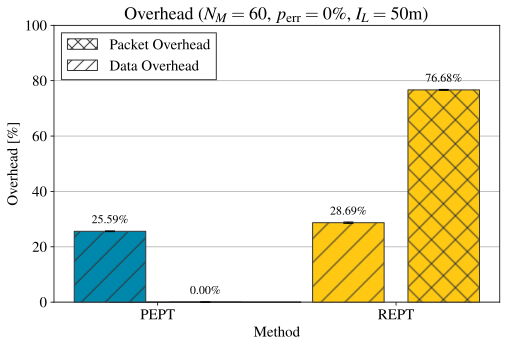

In [38]:
DATA_OVERHEAD_COLOR = color_C3
PACKET_OVERHEAD_COLOR = color_M3
PEPT_COLOR = color_M2
REPT_COLOR = color_C1

fig, ax = plt.subplots(figsize=(8,5))
# ax.set_aspect('auto')
# ax.annotate("", xy=(1.1, 0.5), xycoords="axes fraction")


# PEPT_50_data_overhead_percentage = (PEPT_50_overhead / PEPT_50) * 100
# REPT_50_data_overhead_percentage = (REPT_50_overhead / REPT_50) * 100
# REPT_50_packet_overhead_percentage = (REPT_50_overhead_packet / REPT_50_packet) * 100
# REPT_50_packet_overhead_percentage = (REPT_50_overhead_packet / REPT_50_packet) * 100

methods = ['PEPT', 'REPT']
colors = [DATA_OVERHEAD_COLOR, PACKET_OVERHEAD_COLOR]

# Adjusting the positions for bars
bar_width = 0.3
positions = [0, 0.4, 1, 1.4]

values = [PEPT_50_data, PEPT_50_packet, REPT_50_data, REPT_50_packet]

errors = [PEPT_50_data_CI, PEPT_50_packet_CI, REPT_50_data_CI, REPT_50_packet_CI]
errors_np = np.array(errors)
yerr = np.array([errors_np, errors_np])

# Define the positions and values for 'Data Overhead'
positions_data = [positions[i] for i in range(len(positions)) if i % 2 == 0]
values_data = [values[i] for i in range(len(values)) if i % 2 == 0]
errors_data = [errors[i] for i in range(len(errors)) if i % 2 == 0]

# Define the positions and values for 'Packet Overhead'
positions_packet = [positions[i] for i in range(len(positions)) if i % 2 == 1]
values_packet = [values[i] for i in range(len(values)) if i % 2 == 1]
errors_packet = [errors[i] for i in range(len(errors)) if i % 2 == 1]

ax.grid(axis='y')
# Plot bars
bars_data = ax.bar(positions_data, values_data, color=[PEPT_COLOR, REPT_COLOR], width=bar_width, yerr=errors_data, capsize=5, hatch="/", zorder=20, ec="#333")
bars_packet = ax.bar(positions_packet, values_packet, color=[PEPT_COLOR, REPT_COLOR], width=bar_width, yerr=errors_packet, capsize=5, hatch="X", ec="#333", zorder=20)

# Adjusting x-axis labels to show 'PEPT' and 'REPT' only


ax.bar([0.4],[0], hatch="XX", color="#ffffff", label="Packet Overhead", ec="#333")
ax.bar([0.4],[0], hatch="//", color="#ffffff", label="Data Overhead", ec="#333")


ax.set_xticks([0.2, 1.2])
ax.set_xticklabels(methods)

leg = ax.legend(fancybox=False, framealpha=1.0, loc=2)
leg.get_frame().set_edgecolor('#333')

# Set the Y-axis limit to 100%
ax.set_ylim(0, 100)
ax.set_ylabel('Overhead [\%]')
ax.set_xlabel('Method')



plt.title(f'Overhead ($N_M= {num_malicios}$, $p_\mathrm{{err}} = {per}$\%, $I_L = {lying_intensity}$m)')

# Annotate bars 
for bar, value in zip(bars_data, values_data):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{value:.2f}\%', ha='center', va='bottom', fontsize=12)

for bar, value in zip(bars_packet, values_packet):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{value:.2f}\%', ha='center', va='bottom', fontsize=12)

plt.savefig(f"../figures/overhead_m{num_malicios}_l{lying_intensity}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.savefig(f"../figures/overhead_m{num_malicios}_l{lying_intensity}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.show()



In [21]:
# pl.read_csv(f'../res/v001/PEPT_l500_m60_r0.csv').filter(pl.col("detected_node").is_in([0,5]))

In [22]:
# fig, ax = plt.subplots()

# ax.plot(MGT_100)
# ax.plot(MGT_200)
# ax.plot(MGT_400)

# x,_ = get_detection_time('MGT', num_malicios, 5)
# ax.plot(x)

In [23]:
# PEPT_CI_100

In [24]:
# PEPT_CI_100 = PEPT_CI_100 /9